<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/6f/Dauphine_logo_2019_-_Bleu.png" style="width: 600px;"/> 
</center>  

# Partie 1 - Données

<u>**Introduction :**</u>

<p><div align="justify">
Pour cette première partie, nous avons décidé de construire notre propre base de données. Au lieu de télécharger un fichier prêt à l'emploi, nous allons utiliser la librairie <strong>"yfinance"</strong> qui nous donne accès à une multitude d'informations financières. Les titres sélectionnés pour notre base de données proviennent du <strong>NASDAQ 100</strong>.  Il s'agit de la deuxième plus grande bourse de valeurs aux États-Unis après le NYSE. Le NASDAQ 100 est souvent considéré comme l'indice de référence lorsque nous nous intéressons à des secteurs tels que la technologie, la distribution ou encore les médias. Nous y retrouvons ainsi des entreprises mondialement connues telles que Meta (anciennement Facebook), Apple, Ebay, Amazon, Microsoft, Intel... Il est ainsi intéressant d'étudier cet indice puisqu'il permet d'analyser l'évolution globale de ces secteurs clés.</div></p>
<p><div align="justify">
Notre étude nous limite à l'analyse de 50 titres, nous avons donc effectué un tirage aléatoire sans remise pour constituer notre base de données. Les tickers seront contenus dans la variable <strong>list_tickers</strong> un peu plus loin dans le notebook.</div></p>
<p><div align="justify">
Nous avons également décidé de prendre une période d'observations récente. La date à laquelle commence l'enregistrement des cotations est le <strong>1 janvier 2020</strong> et la date de fin est le <strong>1 janvier 2023</strong> soit <strong>3 ans</strong>. La fréquence d’observation de chaque cotation est hebdomadaire.</div></p>

Nous commençons par installer et importer toutes les librairies dont nous aurons besoin pour cette première partie

In [ ]:
! pip install yfinance

In [1]:
import pandas as pd
import numpy as np
import random
import yfinance as yf
import datetime

Création de la base de données avec les cotations de 50 entreprises du **NASDAQ 100** ainsi que son indice de référence.

In [2]:
# Affectation de l'URL contenant les tickers du NASDAQ 100.
lien = 'https://en.wikipedia.org/wiki/Nasdaq-100'

# Extraction de l'ensemble des tables présentes sur la page wikipedia
tables = pd.read_html(lien)

# Sélection de la table nous intéressant, soit celle contenant les tickers
table_tickers = tables[4]

# Extraction de la colonne "Ticker" et transformation en list
tickers = list(table_tickers["Ticker"])

Il est possible que certains titres posent problèmes : absence de données, cotations aux mauvaises dates... Nous décidons donc de les retirer manuellement.

In [3]:
# Suppression de certains titres pouvant poser problèmes (pas de données)
list_remove = ["ABNB","LCID","CEG","GFS","RIVN"]
for elem in list_remove:
    tickers.remove(elem)

La sélection des titres parmi le NASDAQ 100 se fera **"au hasard"**. Pour que les commentaires soient cohérents avec les résultats que nous trouverons par la suite, nous avons décidé de choisir une **"seed"** particulière. La fixation d'une seed permet d'obtenir le même aléatoire à chaque lancement du programme. **La seed choisi sera la "5".**

In [4]:
# Tirage aléatoire sans remise pour sélectionner de 50 titres parmi ceux du NASDAQ 100
random.seed(5)
list_tickers = random.sample(tickers,50)

# Ajout de l'indice de référence et tri selon l'ordre alphabétique
market_ticker = "^NDX"
list_tickers.append(market_ticker)
list_tickers.sort()

Maintenant que nous disposons des tickers de nos 50 entreprises ainsi que celui de l'indice de référence, nous pouvons utiliser la bibliothèque **yfinance** pour obtenir nos données.

In [5]:
# Téléchargement de la base données selon des paramètres souhaités
debut = datetime.datetime(2020, 1, 1)
fin = datetime.datetime(2023, 1, 1)
df = yf.download(list_tickers,debut,fin,interval='1wk')["Adj Close"]

# Enregistrement du facteur d'annualisation
facteur_annualisation = 52

[*********************100%***********************]  51 of 51 completed


# Optionnel : Faire fonctionner le programme avec d'autres base de données

Les lignes de codes précédentes permettent d'obtenir une base de données utilisable. Si nous souhaitons faire fonctionner notre code à partir d'autre données, nous pouvons l'importer. Pour se faire, il est nécessaire que la base de données ait quelques pré-requis :
- Elle contient les cotations de 50 titres
- La cotation de la place boursière se trouve en dernière colonne
- Le fichier est .csv ou .xlsx
- Le fichier se trouve dans le même répertoire que le fichier Jupyter

In [6]:
# Si vous souhaitez faire fonctionner le programme avec d'autres données mettez 'True' sinon 'False'
activation = False

# Saisie du nom du fichier
nom_fichier = "Finance_Beta_Analysis_Data.csv"

# Saisie de la fréquence des données : daily, weekly, monthly, annually
frequence = "monthly"

# Détermination du facteur d'annualisation
dic_annualisation = {"daily": 250, "weekly": 52,"monthly": 12, "annually": 1}
facteur_annualisation = dic_annualisation[frequence]

# Importation du fichier
if nom_fichier.endswith(".xlsx") and activation:
    df = pd.read_excel(nom_fichier,index_col = 0)
elif nom_fichier.endswith(".csv") and activation:
    df = pd.read_csv(nom_fichier,index_col = 0)

if activation:
    # Création de la liste comportant les tickers
    list_tickers = list(df.columns)
    # Enregistrement du ticker de la place boursière
    market_ticker = list_tickers[-1]

# Partie 2 - Traitement des données

Nous commençons par vérifier la complétude des données.

In [7]:
if df.isnull().values.any():
    print("La base de données n'est pas complète.")
else:
    print("La base de données est complète.")

La base de données est complète.


Nous calculons ensuite les **log-rendements**.

In [8]:
log_returns = np.log(df / df.shift(1))

Il y a encore quelques retraitements à faire pour rendre cette base de données plus "propre". L'index est actuellement les dates mais cela n'est pas vraiment utile compte tenu de l'exercice qui nous attend. Nous allons donc le **réinitialiser** pour avoir l'index de base "1,2,3,4...". 

De plus la toute première ligne de la table est vide puisque nous venons de calculer **n-1 log-rendements** à partir de **n cotations**, elle peut donc être supprimée.

In [9]:
# Réinisialiation de l'index
log_returns = log_returns.reset_index()

# Suppression de la colonne "Date" qui était l'ancien index
log_returns = log_returns.drop(log_returns.columns[0],axis = 1)

# Suppression de la première ligne vide
log_returns = log_returns.drop(0, axis = 0)

# Partie 3 - Stabilité des $β_{i}$

Nous commençons par installer et importer toutes les librairies dont nous aurons besoin pour cette troisième partie.

In [10]:
! pip install statsmodels

In [11]:
from statsmodels.regression.linear_model import OLS
import statsmodels.tools
import matplotlib.pyplot as plt
import seaborn as sns

#### Question 1

Sélectionnez 10 titres au hasard. Pour chacun des n = 10 titres, estimez par les MCO la régression $r_{it} = α_{i} + β_{i}*rm_{t} + e_{it}$ avec les t = 1, ..., 40 premières observations. Le modèle estimé est noté :
$$r_{it} = \hat{α}_{i} + \hat{β}_{i}*r_{mt} + \hat{e}_{it} , t = 1..., 40.$$

On note $β_{i,40}$ le $β_{i}$ de l'actif i obtenu à partir des 40 premières observations.

Encore une fois, nous souhaitons avoir des résultats reproductibles afin que les commentaires puissent être cohérents. Nous utilisons encore une fois la **seed 5** et tirons un échantillon de 10 titres parmi les 50 disponibles.

In [12]:
# Tirage aléatoire sans remise de 10 titres et fixation d'une seed
random.seed(5)
random_titres = random.sample(list_tickers[0:-1],10)

# Affichage des 10 titres du portefeuille
print(random_titres)

['PEP', 'CSX', 'VRSK', 'ILMN', 'SNPS', 'REGN', 'MRNA', 'ADBE', 'MCHP', 'CRWD']


Nous estimons la régression par les MCO (Moindres Carrés Ordinaires), pour ce faire nous utilisons la bibliothèque **statsmodels** afin d'utiliser sa fonction **OLS** (Ordinary Less Squares). Nous utilisons également cette bibliothèque afin d'utiliser la fonction **tools.add_constant** puisque par défaut, la régression se fait sans constante.

In [13]:
# Création d'une liste qui acceuilera les betas et les alphas
list_beta = []
list_alpha = []
# Création d'un dataframe pour stocker les résultats
index = ["beta","alpha"]
OLS_data = pd.DataFrame(index = index, columns=random_titres)

# Enregistrement de la colonne comprenant les rendements de l'indice
X = log_returns[market_ticker].iloc[:40].to_numpy().reshape(-1,1)

# Ajout d'une constante à X puisque la fonction OLS n'en a pas par défaut
X = statsmodels.tools.add_constant(X)

# Boucle sur les 10 titres
for titres in random_titres:
    
    # Sélection des 40 premières observations pour le titre
    Y = log_returns[titres].iloc[:40].to_numpy().reshape(-1, 1)
    
    # Estimation de la régression
    model = OLS(Y,X).fit()
    
    # Récupération des valeurs du beta et du alpha
    beta = model.params[1]
    alpha = model.params[0]
    
    # Enregistrement du beta et du alpha dans des listes
    list_beta.append(beta)
    list_alpha.append(alpha)

# Transfert des valeurs dans le dataframe
OLS_data.loc["beta"] = list_beta
OLS_data.loc["alpha"] = list_alpha

# Affichage du dataframe
OLS_data

,PEP,CSX,VRSK,ILMN,SNPS,REGN,MRNA,ADBE,MCHP,CRWD
beta,0.461343,0.747005,0.608066,0.950999,1.179051,0.136132,-0.364605,1.000667,1.415806,1.503697
alpha,-0.001338,-0.003528,0.001075,-0.006268,0.002499,0.011144,0.039901,0.003038,-0.010562,0.013938


#### Question 2

Estimez la même régression pour le portefeuille équipondéré des $n = 10$ titres $r_{pt} = \frac{1}{n}\sum_{i}^{n}r_{it}$ :

$$r_{pt} = α_{p} + β_{p}*r_{mt} + e_{pt}, t = 1..., 40.$$

On peut montrer que $α_{p} = \frac{1}{n}\sum_{i}^{n}α_{i}$ et $β_{p} = \frac{1}{n}\sum_{i}^{n}β_{i}$


Pour obtenir la régression du portefeuille équipondéré, nous commençons par créer un dataframe contenant nos 10 titres ainsi que leurs log-rendements. Nous pourrons ensuite faire la moyenne des colonnes pour obtenir $r_{pt} = \frac{1}{n}\sum_{i}^{n}r_{it}$ et ainsi estimer notre régression.

In [14]:
# Création du dataframe avec les 10 titres de notre portefeuille
rand_log_returns = log_returns[random_titres]

# Création d'un dataframe qui la moyenne des rendements du portefeuille
moy_rand_log_returns = rand_log_returns.mean(axis=1)

Nous estimons la régression par les MCO.

In [15]:
# Enregistrement de la colonne comprenant les rendements de l'indice
X_eq = log_returns[market_ticker].iloc[:40].to_numpy().reshape(-1,1)

# Ajout d'une constante à X puisque la fonction OLS n'en a pas par défaut
X_eq = statsmodels.tools.add_constant(X)

# Enregistrement de la colonne comprenant les rendements du portefeuille équipondéré
Y_eq = moy_rand_log_returns.iloc[:40].to_numpy().reshape(-1,1)

# Estimation de la régression
model_eq = OLS(Y_eq,X_eq).fit()

# Enregistrement du beta et du alpha dans des listes
beta_eq = model_eq.params[1]
alpha_eq = model_eq.params[0]

D'après l'énoncé :
<div align="center">"On peut montrer que $α_{p} = \frac{1}{n}\sum_{i}^{n}α_{i}$ et $β_{p} = \frac{1}{n}\sum_{i}^{n}β_{i}$"</div>
Nous allons vérifier cela.

In [16]:
print(f"Le beta du portefeuille équipondérée est : {beta_eq}")
print(f"La moyenne des betas des 10 titres est : {np.mean(list_beta)}")

Le beta du portefeuille équipondérée est : 0.7638160893866304
La moyenne des betas des 10 titres est : 0.7638160893866303


In [17]:
print(f"L'alpha du portefeuille équipondérée est : {alpha_eq}")
print(f"La moyenne des alphas des 10 titres est : {np.mean(list_alpha)}")

L'alpha du portefeuille équipondérée est : 0.004989797620896746
La moyenne des alphas des 10 titres est : 0.004989797620896744


#### Question 3

Réestimez les régressions précédentes pour chaque titre et le portefeuille en ajoutant une par une les observations suivantes aux premières 40 observations. On obtiendra pour chaque actif une suite des $β_{i,40}, β_{i,41}, ..., β_{i,T}$ où $T$ est la date finale de l'échantillon. Pour chaque suite de $β_{i,40}, β_{i,41}, ..., β_{i,T}$, calculez :
* la moyenne
* le minimum, le maximum,
* l'écart type

Nous allons commencer par estimer les régressions pour le portefeuille équipondéré. Nos résultats seront stockés dans un dataframe nommé **OLS_data_eq**. Pour ce faire, nous aurons recours à une boucle parcourant les observations une par une au-delà de 40.

In [18]:
# Création d'une liste comprenant les observations au-dessus de 40
observations = list(range(40,len(log_returns.index)+1))

# Création du dataframe pour récuperer les résultats
OLS_data_eq = pd.DataFrame(index = observations)

# Création d'une liste qui acceuilera les betas
list_beta_eq = []

# Boucle sur les observations
for i in observations:
    
    # Enregistrement de la colonne comprenant les rendements de l'indice pour i observations
    X = log_returns[market_ticker].iloc[:i].to_numpy().reshape(-1, 1)
    
    # Ajout d'une constante à X puisque la fonction OLS n'en a pas par défaut
    X = statsmodels.tools.add_constant(X)
    
    # Enregistrement de la colonne comprenant les rendements du portefeuille équipondéré pour i observations
    Y = moy_rand_log_returns.iloc[:i].to_numpy().reshape(-1, 1)
    
    # Estimation de la régression
    model = OLS(Y, X).fit()
    
    # Enregistrement du beta dans la liste
    list_beta_eq.append(model.params[1])
    
# Transfert des valeurs dans le dataframe
OLS_data_eq["Portefeuille eq"] = list_beta_eq

# Affichage du dataframe
OLS_data_eq

,Portefeuille eq
40,0.763816
41,0.773860
42,0.777685
43,0.777481
44,0.779764
...,...
152,0.903806
153,0.905574
154,0.901968
155,0.902823


Nous allons maintenant estimer les régressions pour chaque titre. Nos résultats seront stockés dans un dataframe nommé **OLS_data_titres**. Pour ce faire, nous aurons recours à **deux boucles** parcourant les **observations** une par une au-delà de 40 et les **titres** un par un.

In [19]:
# Création du dataframe pour récuperer les résultats
OLS_data_titres = pd.DataFrame(index = observations, columns=random_titres)

# Boucle sur les titres du portefeuille
for titres in random_titres:
    
    # Réinisialisation de la liste
    list_beta = []
    
    # Boucle sur les observations
    for i in observations:

        # Enregistrement de la colonne comprenant les rendements de l'indice pour i observations
        X = log_returns[market_ticker].iloc[:i].to_numpy().reshape(-1, 1)
        
        # Ajout d'une constante à X puisque la fonction OLS n'en a pas par défaut
        X = statsmodels.tools.add_constant(X)
        
        # Enregistrement de la colonne comprenant les rendements du titre pour i observations
        Y = log_returns[titres].iloc[:i].to_numpy().reshape(-1, 1)
    
        # Estimation de la régression
        model = OLS(Y,X).fit()
    
        # Enregistrement du beta
        beta = model.params[1]
    
        # Enregistrement du beta dans la liste
        list_beta.append(beta)
    
    # Transfert des valeurs dans le dataframe
    OLS_data_titres[titres] = list_beta

# Affichage du dataframe
OLS_data_titres

,PEP,CSX,VRSK,ILMN,SNPS,REGN,MRNA,ADBE,MCHP,CRWD
40,0.461343,0.747005,0.608066,0.950999,1.179051,0.136132,-0.364605,1.000667,1.415806,1.503697
41,0.467555,0.721563,0.606485,0.973151,1.160413,0.173184,-0.273768,1.005661,1.381067,1.523293
42,0.467442,0.725291,0.611469,0.969546,1.162630,0.172804,-0.264397,1.011476,1.383401,1.537185
43,0.467651,0.675867,0.595664,0.993290,1.150559,0.197423,-0.231978,1.024762,1.354712,1.546856
44,0.475123,0.697692,0.602053,0.991410,1.133154,0.193708,-0.207152,1.011800,1.382750,1.517104
...,...,...,...,...,...,...,...,...,...,...
152,0.305887,0.614871,0.614666,1.127667,1.156004,0.304240,0.987826,1.116655,1.184522,1.625723
153,0.306947,0.618816,0.614598,1.127734,1.155862,0.302915,0.998620,1.117639,1.184608,1.628002
154,0.305586,0.626845,0.624767,1.133252,1.144740,0.303870,0.974115,1.095527,1.186246,1.624726
155,0.303746,0.623178,0.620429,1.131181,1.144458,0.307265,0.986648,1.093418,1.186777,1.631127


Nos deux dataframes étant complets, nous pouvons déterminer quelques statistiques descriptives : moyenne, minimum, maximum, écart-type. La méthode **"describe"** peut nous les donner mais nous ne souhaitons pas afficher les centiles.

Nous pouvons commencer par le portefeuille équipondéré :

In [20]:
# Création d'un index pour le dataframe
index = ["Moyenne","Minimum","Maximum","Ecart-type"]

# Création du dataframe pour récuperer les résultats
OLS_data_eq_stats = pd.DataFrame(index = index, columns=["Portefeuille eq"])

# Calcul des statistiques descriptives
OLS_data_eq_stats.loc["Moyenne"] = OLS_data_eq.mean(axis=0)
OLS_data_eq_stats.loc["Minimum"] = OLS_data_eq.min(axis=0)
OLS_data_eq_stats.loc["Maximum"] = OLS_data_eq.max(axis=0)
OLS_data_eq_stats.loc["Ecart-type"] = OLS_data_eq.std(axis=0)

# Affichage du dataframe
OLS_data_eq_stats

,Portefeuille eq
Moyenne,0.858737
Minimum,0.763816
Maximum,0.905835
Ecart-type,0.037427


<u><p>**Commentaires** :</p></u>
<div align="justify">Les régressions sur le portefeuille mettent en évidence un beta de plus en plus important. En effet, lorsque nous ne considérons que 40 observations, le beta du portefeuille (pour cette seed) atteint sa valeur minimale soit 0.804751. Au fur et à mesure que les observations augmentent, le beta croit jusqu'à se stabiliser autour de 1. Le beta final étant de 0.975179, nous pouvons affirmer que le portefeuille subit des variations légèrement diminuées par rapport à celles du marché. Il est difficile de conclure sur la stabilité du beta du portefeuille. Ce dernier ne présente pas de valeurs extrêmes sur la période d'observations et reste dans l'intervalle [0.8,1.0], nous pouvons considérer qu'il est relativement stable malgré la légère croissance constatée. Ce portefeuille garde la même essence : il s'agit d'un portefeuille qui subit des variations légèrement plus faible que celles du marché.
</div>

Nous pouvons maintenant calculer les statistiques descriptives pour chaque titre :

In [21]:
# Création d'un index pour le dataframe
index = ["Moyenne","Minimum","Maximum","Ecart-type"]

# Création du dataframe pour récuperer les résultats
OLS_data_stats = pd.DataFrame(index = index, columns=random_titres)

# Calcul des statistiques descriptives
OLS_data_stats.loc["Moyenne"] = OLS_data_titres.mean(axis=0)
OLS_data_stats.loc["Minimum"] = OLS_data_titres.min(axis=0)
OLS_data_stats.loc["Maximum"] = OLS_data_titres.max(axis=0)
OLS_data_stats.loc["Ecart-type"] = OLS_data_titres.std(axis=0)

# Affichage du dataframe
OLS_data_stats

,PEP,CSX,VRSK,ILMN,SNPS,REGN,MRNA,ADBE,MCHP,CRWD
Moyenne,0.383265,0.586314,0.586603,1.071061,1.183236,0.232587,0.587701,1.065028,1.283387,1.608191
Minimum,0.287142,0.512801,0.545575,0.950999,1.104968,0.136132,-0.364605,1.000667,1.154561,1.459888
Maximum,0.480202,0.747005,0.631454,1.153309,1.267652,0.338323,1.026495,1.117722,1.415806,1.754297
Ecart-type,0.062467,0.052295,0.023685,0.053845,0.04707,0.057195,0.373264,0.028935,0.079384,0.061226


<u><p>**Commentaires** :</p></u>
<div align="justify">Les régressions sur les titres mettent en évidence des résultats plus diversifiés. En effet, lorsque nous ne nous intéressons uniquement aux moyennes, il est possible de retrouver les trois grandes catégories de valeurs :
</div>
<div align="justify">- Le titre MRNA qui correspond à l'entreprise Moderna peut être qualifié de valeur "refuge". Son beta est en moyenne de 0.587701 avec un minimum à -0.364605. Le titre subit donc des mouvements très faibles (voire inverse) à ceux du marché. Il s'agit d'une entreprise pharmaceutique et ce secteur est particulièrement connu pour être une valeur refuge tout comme les secteurs du tabac, de l'alcool, des armes. Le titre REGN qui possède un beta faible (0.232587) fait également parti du secteur pharmaceutique.
</div>
<div align="justify">- De très nombreuses entreprises ont des betas avec des valeurs proches de 1 (PDD, ILMN, ADBE) ce qui signifie qu'elles répliquent exactement les mouvements du marché.
</div>
<div align="justify">- Enfin, le dernier type de titres sont ceux ayant un beta supérieur à 1, ces derniers vont subir des variations amplifiées par rapport à celles du marché et sont donc très dépendants de la bonne santé de l'activité économique.
</div>
<p><div align="justify">La notion de stabilité des betas peut être évaluer en s'intéressant aux valeurs extrêmes ainsi qu'à l'écart-type. En l'occurrence, le maximum et le minimum peuvent être très écartés de la valeur moyenne dans le cas du titre MRNA ou encore PDD mais ce phénomène reste minime. Les écarts-types ne sont pas anormalement élevés, les betas subissent des variations mais ces dernières ne sont pas suffisamment importantes pour modifier considérablement la nature d'un titre (contra-cyclique, cyclique ou pro-cyclique).</p>
</div></p>

#### Question 4

Faites les représentations graphiques des $β_{i,40}, β_{i,41}, ..., β_{i,T}$ et de leur intervalle de confiance à 95% en fonction du temps pour chaque titre et le portefeuille. Commentez la stabilité des β des titres individuels et du portefeuille.

Ces quelques lignes de codes permettent de s'assurer que le graphique est centré.

In [22]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Commençons par la représentation graphique de chaque titre du portefeuille :

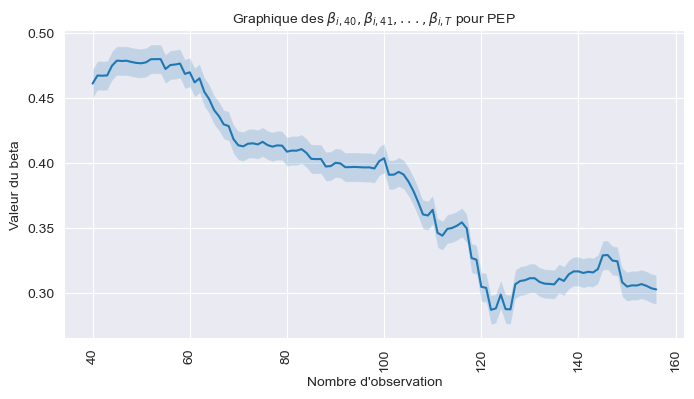

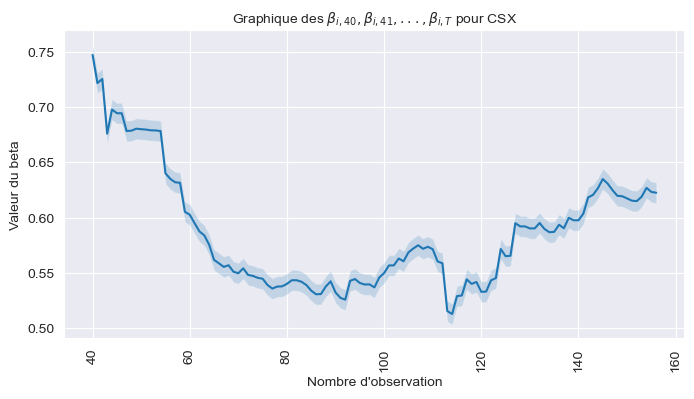

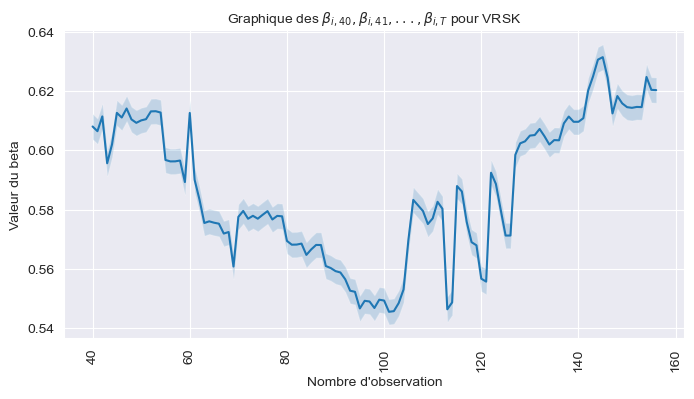

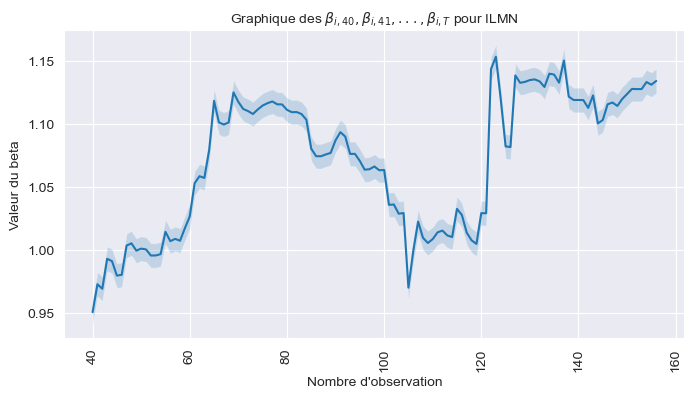

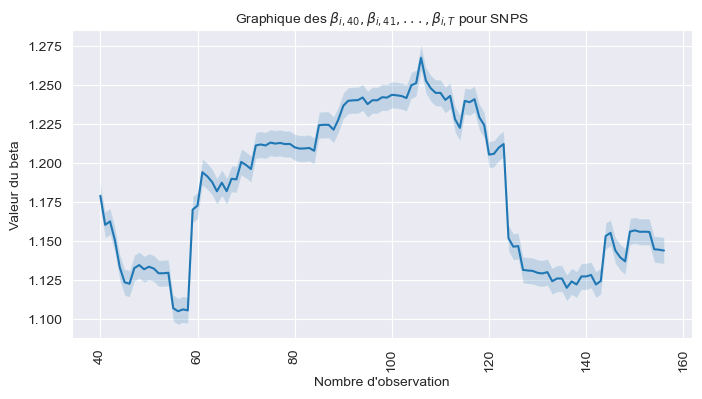

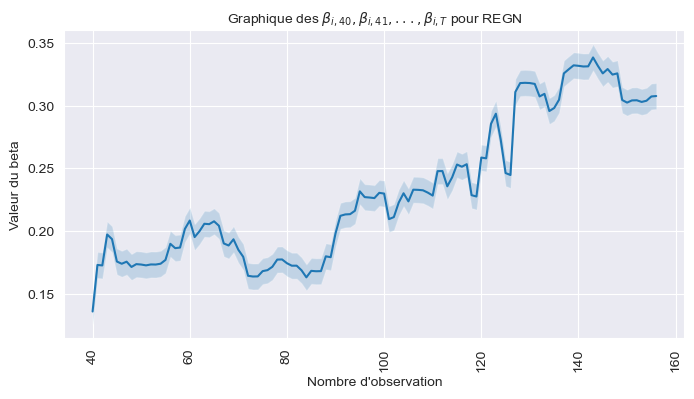

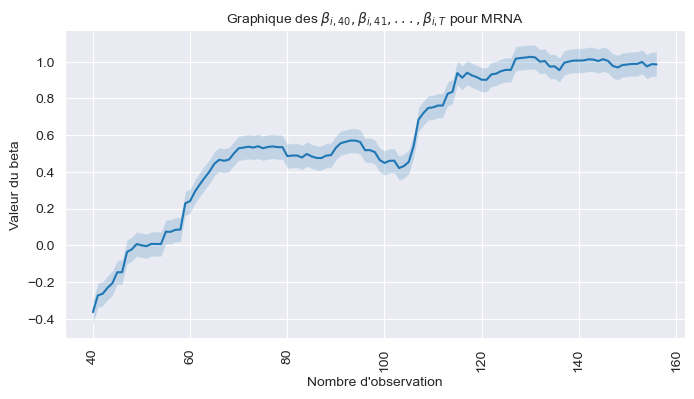

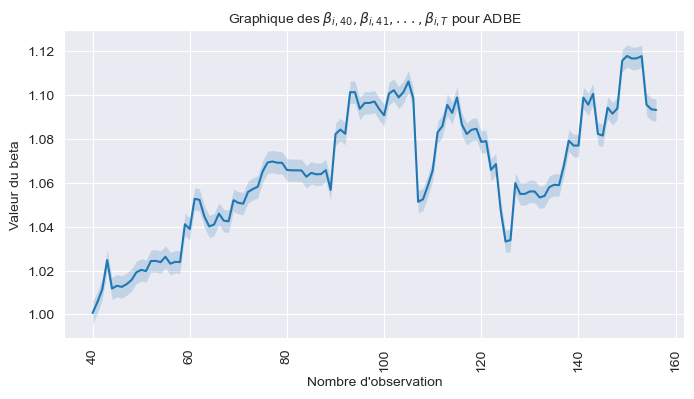

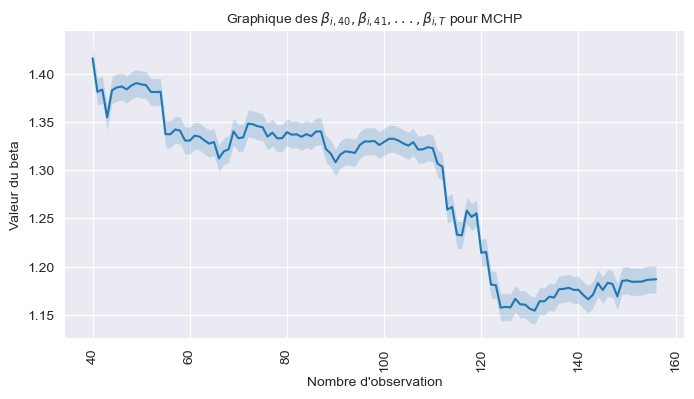

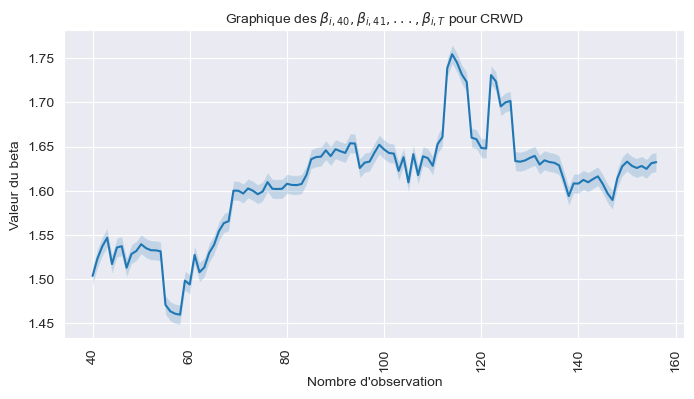

In [23]:
# Ajout d'un fond au graphique
sns.set_style("darkgrid")

# Boucle sur les titres du portefeuille
for titres in random_titres:

    # Initialisation du graphique
    port_graph = plt.figure()

    # Enregistrement des données
    y = OLS_data_titres[titres]
    x = OLS_data_titres.index

    # Ajout des données
    plt.plot(x, y)

    # Calcul de l'intervalle de confiance à 95%
    borne_inf = y - 1.96 * (np.std(y) / np.sqrt(len(y)))
    borne_sup = y + 1.96 * (np.std(y) / np.sqrt(len(y)))

    # Ajout de l'intervalle de confiance au graphique
    plt.fill_between(x, borne_inf, borne_sup, alpha=0.2)

    # Ajout de noms aux axes
    plt.xlabel("Nombre d'observation")
    plt.ylabel("Valeur du beta")

    # Rotation de l'axe des abscisses
    plt.xticks(rotation ='vertical')

    # Ajout d'un titre
    plt.title("Graphique des $β_{i,40}, β_{i,41}, ..., β_{i,T}$ pour " + titres , fontsize=10)

    # Redimensionnement du graphique
    plt.gcf().set_size_inches(8, 4)

    # Affichage du graphique
    plt.show()

Nous pouvons maintenant faire la représentation graphique pour le portefeuille :

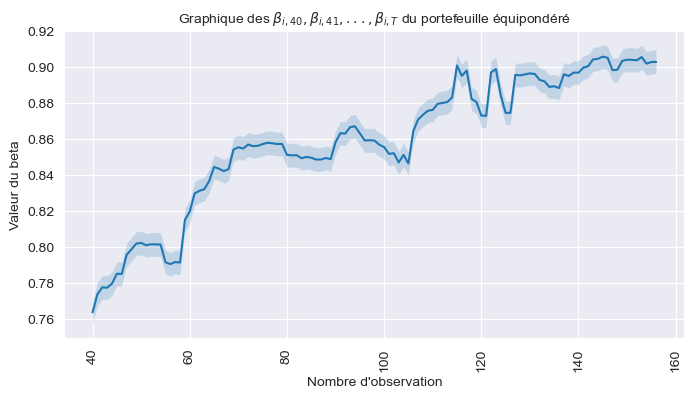

In [24]:
# Initialisation du graphique
port_graph = plt.figure()

# Enregistrement des données
y = OLS_data_eq["Portefeuille eq"]
x = OLS_data_eq.index

# Ajout des données
plt.plot(x, y)

# Calcul de l'intervalle de confiance à 95%
borne_inf = y - 1.96 * (np.std(y) / np.sqrt(len(y)))
borne_sup = y + 1.96 * (np.std(y) / np.sqrt(len(y)))

# Ajout de l'intervalle de confiance au graphique
plt.fill_between(x, borne_inf, borne_sup, alpha=0.2)

# Ajout de noms aux axes
plt.xlabel("Nombre d'observation")
plt.ylabel("Valeur du beta")

# Rotation de l'axe des abscisses
plt.xticks(rotation ='vertical')

# Ajout d'un titre
plt.title("Graphique des $β_{i,40}, β_{i,41}, ..., β_{i,T}$ du portefeuille équipondéré" , fontsize=10)

# Redimensionnement du graphique
plt.gcf().set_size_inches(8, 4)

# Ajout d'un fond au graphique
sns.set_style("darkgrid")

# Affichage du graphique
plt.show()

<u><p>**Commentaires** :</p></u>
<div align="justify"> Les représentations graphiques nous permettent d'affiner nos commentaires sur la stabilité des betas. Si nous nous intéressons aux graphiques individuels pour les titres, nous constatons un retour à la moyenne pour certains d'entre eux. Cette observation n'est cependant pas systématique puisque de nombreux titres subissent une hausse ou une baisse continue avec l'augmentation du nombre d'observations. La représentation graphique des betas du portefeuille illustre parfaitement cela puisque le beta ne fait qu'augmenter au fur et à mesure que les observations augmentent. Il n'est donc pas stable d'après nos résultats.
</div>

# Partie 4 - Risque diversifiable et non diversifiable

Nous commençons par installer et importer toutes les libraires dont nous aurons besoin pour cette troisième partie.

In [25]:
!pip install scipy

In [26]:
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns

#### Question 1

Pour chacun des 50 titres, estimez la régression : $r_{it} = α_{i} + β_{i}*r_{mt} + e_{it}$ , $t = 1..., T$ en utilisant toutes les observations

Nous allons estimer les régressions pour chaque titre. Nos résultats seront stockés dans un dataframe nommé **OLS_data_2**. Pour ce faire, nous aurons recours à **une seule boucle parcourant les titres un par un**.

In [27]:
# Création d'un index pour le dataframe
index = ["beta","alpha"]

# Création du dataframe pour récuperer les résultats
OLS_data_2 = pd.DataFrame(index = index, columns=list_tickers[0:-1])

# Création du dataframe pour les résidus
OLS_residus = pd.DataFrame(index = log_returns.index , columns = log_returns.columns[0:-1])

# Création d'une liste qui acceuilera les betas
list_beta_2 = []

# Création d'une liste qui acceuilera les alphas
list_alpha_2 = []

# Enregistrement de la colonne comprenant les rendements de l'indice pour toutes les observations
X = log_returns[market_ticker].iloc[:].to_numpy().reshape(-1,1)

# Ajout d'une constante à X puisque la fonction OLS n'en a pas par défaut
X = statsmodels.tools.add_constant(X)

# Boucle sur les 50 titres
for titres in list_tickers[0:-1]:

    # Enregistrement de la colonne comprenant les rendements du titre pour toutes les observations
    Y = log_returns[titres].iloc[:].to_numpy().reshape(-1, 1)

    # Estimation de la régression
    model = OLS(Y,X).fit()

    # Enregistrement du beta et du alpha
    beta = model.params[1]
    alpha = model.params[0]
    
    # Calcul et ajout des résidus
    OLS_residus[titres] = model.resid
    
    # Enregistrement du beta et du alpha dans la liste
    list_beta_2.append(beta)
    list_alpha_2.append(alpha)


# Transfert des valeurs dans le dataframe
OLS_data_2.loc["beta"] = list_beta_2
OLS_data_2.loc["alpha"] = list_alpha_2

# Affichage du dataframe
OLS_data_2

,AAPL,ADBE,ADI,ADSK,ALGN,AMAT,AMGN,AMZN,ANSS,ASML,...,QCOM,REGN,ROST,SBUX,SNPS,TEAM,TXN,VRSK,WBD,WDAY
beta,1.072491,1.093126,0.804837,1.214402,1.270807,1.270946,0.150788,1.281828,1.03253,1.268139,...,1.080551,0.307603,0.853996,0.747965,1.143894,1.419633,0.724998,0.620336,1.038756,1.270482
alpha,0.002228,-0.001428,0.001287,-0.001675,-0.003617,0.001394,0.000995,-0.002557,-0.001794,0.002317,...,0.000302,0.003808,-0.001144,0.000146,0.003593,-0.001906,0.001093,0.000141,-0.009227,-0.001941


#### Question 2

Calculez et reportez dans un tableau la moyenne, le maximum, le minimum, l'écart type, le skewness et le kurtosis des 50 {$\hat{β}_{i}$} $i = 1, ..., N = 50$. Représentez l'histogramme des {$\hat{β}_{i}$} $i = 1, ..., N$ et commentez.

Nos régressions étant calculées, nous pouvons déterminer quelques statistiques descriptives : moyenne, maximum, maximum, écart-type, skewness, kurtosis. Nos résultats seront stockés dans un dataframe nommé **OLS_data_2_stats**.

In [28]:
# Création d'un index pour le dataframe
index = ["Moyenne","Minimum","Maximum","Ecart-type","Skewness","Kurtosis"]

# Création du dataframe pour récuperer les résultats
OLS_data_2_stats = pd.DataFrame(index = index, columns=["Statistiques beta"])

# Calcul des statistiques descriptives
OLS_data_2_stats.loc["Moyenne"] = OLS_data_2.loc["beta"].mean()
OLS_data_2_stats.loc["Minimum"] = OLS_data_2.loc["beta"].min()
OLS_data_2_stats.loc["Maximum"] = OLS_data_2.loc["beta"].max()
OLS_data_2_stats.loc["Ecart-type"] = OLS_data_2.loc["beta"].std()
OLS_data_2_stats.loc["Skewness"] = OLS_data_2.loc["beta"].skew()
OLS_data_2_stats.loc["Kurtosis"] = OLS_data_2.loc["beta"].kurtosis()

# Affichage du dataframe
OLS_data_2_stats

,Statistiques beta
Moyenne,0.965544
Minimum,0.150788
Maximum,1.758895
Ecart-type,0.387934
Skewness,-0.156146
Kurtosis,-0.456591


Représentons maintenant l'histogramme :

<Figure size 200x400 with 0 Axes>

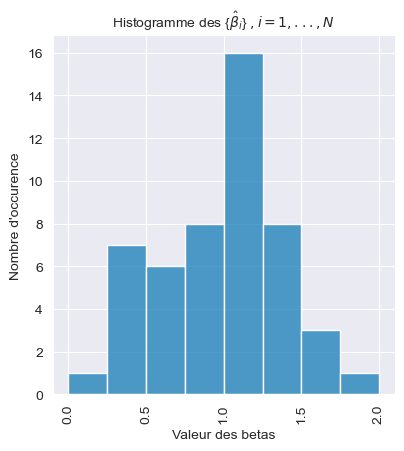

In [29]:
# Initialisation du graphique
hist_beta = plt.figure(figsize=(2,4))

# Il n'est pas possible de mettre un float comme step pour range()
step = [x * 0.25 for x in range(0, 10)]

# L'histogramme est un peu capricieux puisqu'il ne sépare pas chaque rectangle automatiquement
# Nous sommes donc obliger d'écrire quelques ligne de cods en plus pour avoir un saut de 0.25 quelques soient les données
lower_bound = round(min(list_beta_2)/0.25)*0.25 - 0.25
higher_bound = round(max(list_beta_2)/0.25)*0.25 + 0.25
step = np.arange(lower_bound,higher_bound + 0.25, 0.25)

# Création de l'histogramme et ajout de couleur
sns.displot(data = list_beta_2 ,bins = step, color="#167DB8")

# Ajout de noms aux axes
plt.xlabel("Valeur des betas")
plt.ylabel("Nombre d'occurence")

# Rotation de l'axe des abscisses
plt.xticks(rotation ='vertical')

# Ajout d'un titre
plt.title("Histogramme des {$\hat{β}_{i}$} $ , i = 1, ..., N$ ", fontsize=10)

# Redimensionnement du graphique
plt.gcf().set_size_inches(4, 4)

# Ajout d'un fond au graphique
sns.set_style("darkgrid")

# Affichage du graphique
plt.show()

<u><p>**Commentaires** :</p></u>
<p><div align="justify"> Le beta du portefeuille de marché, c'est-à-dire celui contenant tous les titres, est égal à 0.97. Nous obtenons donc un portefeuille qui réplique presque les mêmes variations que le marché. Le portefeuille est diversifié puisqu'il contient des titres avec des betas bien différents les uns des autres. Les betas des titres sont les plus concentrés dans l'intervalle [1.0,1.25]. La distribution n'est pas totalement symétrique puisqu'il y a davantage de titres à gauche de cet intervalle qu'à droite. Les titres ont donc tendance à répliquer ou diminuer les mouvements du marché. Le skewness négatif (-0.17) indique que la distribution se décale davantage vers la droite de la médiane. Le kurtosis négatif (-0.29) signifie que la distribution est plutôt aplatie par rapport à une loi normale. Disposant du kurtosis et du skewness, nous pouvons effectuer un test de normalité de Jarque-Bera pour savoir si les betas suivent une loi normale. L'hypothèse nulle est que les données suivent une loi normale et l'hypothèse alternative est que les données ne suivent pas cette loi normale.
</div></p>
<p><div align="justify">Le beta est un instrument intéressant mais il ne faut oublier que les cotations des titres sont aussi liées à des facteurs extérieurs aux betas. La stabilité de ce dernier au cours du temps est souvent remise en cause. La plupart des betas tendent automatiquement vers 1 lorsque nous utilisons des historiques volumineux de données pour le calculer. Certains auteurs viennent même à parler de "mort du beta" (Dumas B. et Zisswiller R.)
</div></p>

In [30]:
print(f"La statistique de Jarque-Bera est : {jarque_bera(list_beta_2).statistic}")
print(f"La p-value est : {jarque_bera(list_beta_2).pvalue}")

La statistique de Jarque-Bera est : 0.7759260593428556
La p-value est : 0.6784374248549765


<div align="justify"> D'après ces résultats, il n'est pas possible de rejeter l'hypothèse nulle de normalité des données. La distribution des betas suit donc une loi normale.
</div>

#### Question 3

Calculez le risque non-diversifiable et le risque diversifiable du portefeuille équipondéré de 10 titres

Nous commençons par calculer la variance de l'indice de la place boursière : $σ^{2}_{m}$

In [31]:
var_m = np.var(log_returns[market_ticker])

Nous calculons également les pondérations, en l'occurrence, nous avons un portefeuille équipondéré avec 10 titres :

In [32]:
# Enregistrement du nombre de titre
nbre = 10

# Calcul des pondérations
w = 1/nbre

# Transformation en array pour le calcul matriciel
w = np.array([w]*nbre)

Nous récupérons également les betas de nos 10 titres qui seront nécessaires pour le calcul de la variance du portefeuille :

In [33]:
# Création d'une liste pour les betas
beta = []

# Boucle sur les titres du portefeuille
for titres in random_titres:
    
    # Récupération des betas calculés à la question 1
    beta.append(OLS_data_2[titres].loc["beta"])

# Transformation en array pour le calcul matriciel
beta = np.array(beta)

Nous pouvons calculer la variance d'après la formule suivante : $V(r_{pt}) = (β^{'}×w)^{2}σ^{2}_{m} + w^{'}Ω_{e}w$

In [34]:
# Création du dataframe avec les 10 titres de notre portefeuille
rand_log_returns = log_returns[random_titres]

# Création du dataframe pour récuperer les résultats
portfolio_cov = pd.DataFrame(0,index = rand_log_returns.columns, columns=rand_log_returns.columns)
for i in rand_log_returns.columns:
    portfolio_cov.loc[i,i] = OLS_residus[i].var()

var = (np.dot(np.dot(beta.T,w)**2,var_m) + np.dot(np.dot(w.T,portfolio_cov),w))*facteur_annualisation

Nous calculons également le beta du portefeuille : $β_{p} = \frac{1}{n}\sum_{i}^{n}β_{i}×w_{i}$. Le portefeuille étant équipondéré, il s'agit simplement de la moyenne des betas.

In [35]:
beta_portfolio = sum(beta)/nbre
print(f"Le beta du portefeuille est : {beta_portfolio}")

Le beta du portefeuille est : 0.9029033748682623


Nous pouvons calculer le risque systématique aussi appelé risque non diversifiable : $β^{2}_{p}σ^{2}_{m}$

In [36]:
# Calcul de la variance systématique
variance_sys = np.dot(np.dot(beta.T,w)**2,var_m)*facteur_annualisation

# Calcul du risque systématique
risk_sys = np.sqrt(variance_sys)

# Affichage du risque systématique
print(f"Le risque systématique est : {risk_sys}")

Le risque systématique est : 0.11115879507397347


Nous pouvons calculer le risque spécifique aussi appelé risque diversifiable : $\frac{1}{n^{2}}\sum_{i}^{n}σ^{2}_{e_{i}}$

In [37]:
# Calcul de la variance spécifique
variance_spe = var - variance_sys

# Calcul du risque spécifique
risk_spe = np.sqrt(variance_spe)

# Affichage du risque spécifique
print(f"Le risque systématique est : {risk_spe}")

Le risque systématique est : 0.05893592126358138


#### Question 4

Pour chaque portefeuille de $N = 11, 12, 13...., 99, 100$ titres obtenu en ajoutant un à un chaque titre au portefeuille initial, calculez :
* son $β_{p}$
* son risque non-diversifiable et son risque diversifiable

Pour ce faire, nous créons une liste avec tous les titres qui ne sont pas encore dans le portefeuille équipondéré initial.

In [38]:
# Création d'une nouvelle liste
tickers_portfolio = list_tickers[:-1]

# Boucle sur les titres déjà en portefeuille
for elem in random_titres:
    
    # Suppresion des titres
    tickers_portfolio.remove(elem)

Nos résultats seront stockés dans un dataframe nommé **portfolio_info**.

In [39]:
# Création d'un index pour le dataframe
index = ["Beta portfeuille","Variance","Risque total","Risque non diversifiable","Risque diversifiable"]

# Création de colonnes pour le dataframe
nom_cols = list(range(10,len(list_tickers)))

# Création du dataframe pour récuperer les résultats
portfolio_info = pd.DataFrame(index = index, columns=nom_cols)

# Enregistrement de la colonne du portefeuille équipondéré avec 10 titres
portfolio_info[10] = [np.mean(beta), var, risk_spe + risk_sys, risk_sys, risk_spe]

Nous ajoutons ensuite un a un les titres à l'aide d'une boucle

In [40]:
# Pandas affiche une suggestion inutile pour l'une des lignes de codes.
# Pour éviter de reçevoir un avertissement à chaque passage dans la boucle, nous les désactivons.
pd.options.mode.chained_assignment = None

# Boucle sur les titres
for titres in tickers_portfolio:
    
    # Incrémentation du nombre de titre
    nbre += 1
    
    # Calcul des pondérations
    w = 1/nbre
    
    # Transformation en array pour le calcul matriciel
    w = np.array([w]*nbre)
    
    # Ajout du nouveau titre dans le dataframe pour le calcul des covariances
    rand_log_returns[titres] = log_returns[titres]
    
    # Ajout du nouveau beta à l'array
    beta = np.append(beta, OLS_data_2.loc["beta",titres])
    
    # Création du dataframe pour récuperer les résultats
    portfolio_cov = pd.DataFrame(0,index = rand_log_returns.columns, columns=rand_log_returns.columns)
    for i in rand_log_returns.columns:
        portfolio_cov.loc[i,i] = OLS_residus[i].var()

    # Calcul de la variance du portefeuille
    var = (np.dot(np.dot(beta.T, w) ** 2, var_m) + np.dot(np.dot(w.T, portfolio_cov), w))*facteur_annualisation

    # Calcul du beta du portefeuille
    beta_portfolio = sum(beta)/nbre

    # Calcul du risque systématique (risque non-diversifiable)
    variance_sys = np.dot(np.dot(beta.T, w) ** 2, var_m)*facteur_annualisation
    risk_sys = np.sqrt(variance_sys)
    
    # Calcul du risque spécifique (risque diversifiable)
    variance_spe = var - variance_sys
    risk_spe = np.sqrt(variance_spe)

    # Transfert des valeurs dans le dataframe
    portfolio_info[nbre] = [beta_portfolio, var ,risk_spe + risk_sys, risk_sys, risk_spe]

# Affichage du dataframe
portfolio_info

,10,11,12,13,14,15,16,17,18,19,...,41,42,43,44,45,46,47,48,49,50
Beta portfeuille,0.902903,0.918320,0.908863,0.932366,0.956541,0.977501,0.925831,0.946772,0.951537,0.968200,...,0.951328,0.954246,0.956763,0.959577,0.957230,0.952681,0.962616,0.957666,0.959321,0.965544
Variance,0.015830,0.015710,0.015051,0.015430,0.016003,0.016435,0.014751,0.015191,0.015185,0.015563,...,0.014387,0.014452,0.014509,0.014570,0.014490,0.014338,0.014629,0.014464,0.014517,0.014684
Risque total,0.170095,0.167167,0.162207,0.162265,0.163973,0.164536,0.155924,0.156617,0.155377,0.156002,...,0.143003,0.142982,0.142980,0.142916,0.142379,0.141412,0.142687,0.141638,0.141949,0.142410
Risque non diversifiable,0.111159,0.113057,0.111893,0.114786,0.117762,0.120343,0.113982,0.116560,0.117146,0.119198,...,0.117120,0.117480,0.117790,0.118136,0.117847,0.117287,0.118510,0.117901,0.118104,0.118871
Risque diversifiable,0.058936,0.054110,0.050314,0.047479,0.046210,0.044194,0.041942,0.040057,0.038231,0.036804,...,0.025882,0.025502,0.025190,0.024780,0.024532,0.024124,0.024177,0.023737,0.023845,0.023540


In [41]:
x1 = portfolio_info.columns
y1 = portfolio_info.loc["Risque total"]
y2 = portfolio_info.loc["Risque non diversifiable"]
y3 = portfolio_info.loc["Risque diversifiable"]

#### Question 5

Faites la représentation graphique de la variance du portefeuille, du risque diversifiable et risque non-diversifiable (en ordonnée) en fonction du nombre d'actifs du portefeuille (en abscisse). Commentez vos résultats

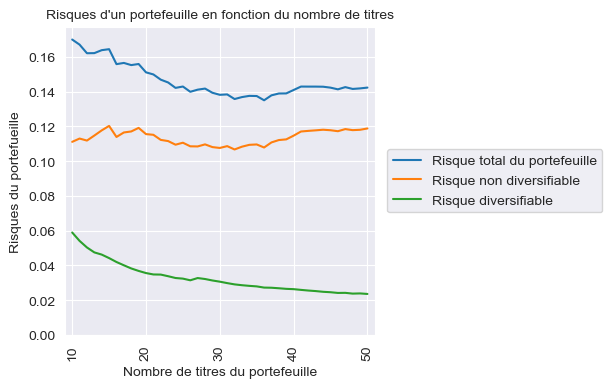

In [42]:
# Initialisation du graphique
port_graph = plt.figure(figsize=(4,4))

# Ajout des données
plt.plot(x1,y1,label="Risque total du portefeuille")
plt.plot(x1,y2,label="Risque non diversifiable")
plt.plot(x1,y3,label="Risque diversifiable")

# Ajout d'une borne inférieure
plt.xlim(left=9, right = 51)
plt.ylim(bottom=0)

# Ajout de noms aux axes
plt.xlabel("Nombre de titres du portefeuille")
plt.ylabel("Risques du portefueille")

# Rotation de l'axe des abscisses
plt.xticks(rotation ='vertical')

# Ajout d'un titre
plt.title("Risques d'un portefeuille en fonction du nombre de titres", fontsize=10)

# Ajout de la légende
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

# Redimensionnement du graphique
plt.gcf().set_size_inches(4, 4)

# Ajout d'un fond au graphique
sns.set_style("darkgrid")

# Affichage du graphique
plt.show()

<u><p>**Commentaires** :</p></u>
<p><div align="justify">Nous avons décidé de représenter le risque total et non la variance du portefeuille dans le graphique, la variance est tout de même présente dans le dataframe plus haut. Raisonner avec l'écart-type permet d'avoir une unité de mesure comparable à celle des rendements, par ailleurs la représentation graphique est plus parlante.
</div></p>
<p><div align="justify">Le risque diversifiable (en vert) diminue avec le nombre de titres, ce phénomène est appelé "diversification". Le fait d'inclure davantage de titres permet de répartir l'investissement dans des secteurs différents et ainsi d'éviter le risque idiosyncratique, c'est-à-dire celui qui affecte une entreprise en particulier (accidents, mauvaise gestion...). En théorie, le risque spécifique est censé tendre vers 0 lorsque le nombre de titres tend vers l'infini. Cependant, dans la réalité, le gain en termes de risque va être compensé par le coût de gestion supplémentaire. Il est donc important de ne pas considérer que la théorie.
</div></p>
<p><div align="justify">Le risque total du portefeuille (en bleu) diminue de manière importante au début puis la réduction est de moins en moins importante. Le risque total du portefeuille ne pourra pas descendre en dessous d'un niveau minimum, ce niveau est appelé "portefeuille de marché", il s'agit du portefeuille qui contient, avec leurs pondérations respectives, l'ensemble des titres disponibles sur le marché. Le risque systématique (en orange) reste stable dans le temps et ne diminuera pas même si le nombre de titres augmente.
</div></p>